# Offer Metrics Notebook

#### Section 1: Data Pre-processing
- Define offer (user inputs)
- import packages
- set up connection to replica
- pull in transactions
- make additional variables required

#### Section 2: Calculating Results
- **redemptions scaler**: use this to inflate flux transaction and customer volumes
- **results_df1**: unique customer, customer %, total redemptions. By acquired and previous and all redeemers.
- **results_df1b**: aquired customer volume as a % of total new customers over the offer live period.
- **results_df2**: atf, atv, abs metrics. By acquired and previous and all redeemers.
- **results_df3**: ATF of redeemers vs non-redeemers
- **results_df4a & results_df4b** : volume (a) or percent (b) of acquired and previous customers that have made repeat purcahses over 12 weeks following redemption
- **results_df5**: ATV of redeemers vs non-redeemers
- **results_df6**: Average Basket Size of redeemers vs non-redeemers
- **results_df7**: Most popular day of week to redeem
- **results_df8**: Most popular time of day to redeem
- **results_df9**: % of acquired and previous that made a second redemption
- **results_df10**: Spend, ATV and ATF by weeks since redemption - non-acquired customers (redeemers and non-redeemers)
- **results_df11**: Spend, ATV and ATF by weeks since redemption - acquired customers (redeemers)
- **results_df12**: Revenue impact calculation for non-acquired customers
- **results_df13**: Revenue impact calculation for acquired customers
- **results_df14**: Cost of offer for existing and acquired
- **results_df15**: ROI 



------------------------

#### Once notebook has run through, uncomment results below to quickly view results dataframes

In [567]:
redemptions_scaler

36.53721682847896

In [568]:
results_df1

redeemer segment,acquired,previous,all
metric,,,
unique customers,22.000000,136.000000,158.0
customer %,13.924051,86.075949,100.0
total redemptions,38.000000,271.000000,309.0


In [582]:
results_df1b

0.4862953138815208

In [569]:
results_df2

redeemer segment,acquired,previous,all
metric,,,
ATV,3.387143,4.788092,4.593023
weekly_ATF,0.020548,0.123288,0.108982
offer_period_ATF,1.500000,9.000000,7.955696
yearly_ATF,1.071429,6.428571,5.682640
weekly_ACV,0.263836,1.045890,0.936997
offer_period_ACV,19.260000,76.350000,68.400759
Average Basket Size,1.000000,1.528571,1.454973


In [551]:
results_df3

In [552]:
#results_df4a

In [553]:
#results_df4b

In [323]:
#results_df5

In [324]:
#results_df6

In [325]:
#results_df7

In [326]:
#results_df8

In [327]:
#results_df9

In [328]:
#results_df10

In [ ]:
#results_df11

In [509]:
#results_df12

In [ ]:
#results_df13

In [ ]:
#results_df13

--------------------

# Section 1

### User inputs

In [1]:
retailer = 'schuh'
offer_name = 'schuh dr martens reusable jute'
offer_name2 = 'one size - schuh dr martens reusable jute' #appears differently for schuh 

sql_flux = 'schuh_txns.sql'
sql_retailer = 'schuh_all.sql'

#restrictions for revenue impact and ROI calculations, may only want to look at the impact over a certain time 
#if only want to cosider the whole period offer has been live for, then can remove where offer_week_start & offer_week_end are rederred to 
offer_week_start = '2019-06-01' #first week we want to consider
offer_week_end = '2021-04-21' #last week we want to consider
measurement_weeks = 8 #this is how long pre and post the week we want to measure spend for

### Packages and definitions needed for python 

In [2]:
# install required packages
import pandas as pd
import numpy as np
from utils.database import query_from_file
import datetime
import time
import psutil
from datetime import datetime, timedelta
from utils import style
import matplotlib
path = '/Users/jennamiles/Documents/credentials'

/Users/jennamiles/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

In [4]:
#parameters for plotting
matplotlib.rcParams['font.sans-serif'] = 'Akkurat Pro'
matplotlib.rcParams['font.serif'] = 'Vesterbro'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = '15'

matplotlib.rcParams['figure.figsize'] = (50, 15)
matplotlib.rcParams['figure.titlesize'] = '25'

matplotlib.rcParams['axes.titlesize'] = '25'
matplotlib.rcParams['axes.labelsize'] = '15'
matplotlib.rcParams['axes.titlepad'] = '25'
matplotlib.rcParams['axes.labelpad'] = '30'
matplotlib.rcParams['xtick.labelsize'] = '15'
matplotlib.rcParams['ytick.labelsize'] = '20'

### Read in transactions for retailer

In [6]:
#read in pure data from SQL query:
start = time.time()
df = query_from_file(sql_flux)
df_all = query_from_file(sql_retailer)
end = time.time()
query_time = end-start
print(f"Queries took {query_time:.2f} seconds")

Queries took 614.93 seconds


### Data pre-processing
- Creates new **date** variables that will be useful

In [10]:
#additional date columns that will be useful 
df['date'] = df['transaction_date'].dt.date
df['day'] = df['transaction_date'].dt.isocalendar().day
df['week'] = df['transaction_date'].dt.isocalendar().week
df['week_start'] = (df['transaction_date'] - pd.TimedeltaIndex(df['transaction_date'].dt.dayofweek, unit='D')).dt.date
df['month'] = df['transaction_date'].dt.month
df['year'] = df['transaction_date'].dt.year

- Change data types where necessary

In [11]:
#change price to a numeric variable 
df['price'] = pd.to_numeric(df['item_price'])

- Creates a variable that indicates the **receipt number** for that customer
- This will be used to segments new and existing customers
- Warning - we can only see if they are new customers within Flux, so they may have a receipt count of 1 even though transacted before 

In [15]:
df_receipts = df[['customer_id','receipt_id','total_amount','transaction_date','date','month','week','location_id']].drop_duplicates().sort_values(['customer_id','transaction_date'])
df_receipts['receipt_count'] = df_receipts.groupby(['customer_id'])['receipt_id'].cumcount()+1
df = pd.merge(df, df_receipts[['receipt_count','customer_id','receipt_id']], on = ['customer_id','receipt_id'], how = 'left' )

- identify transactions on the chosen offer
- save the receipts containing the offer to an array to reference another time
- useful for flux and all redemptions

In [25]:
df_offer = df[df['name'].str.lower() == offer_name].copy()
df_all_offer = df_all[df_all['name'].str.lower() == offer_name2].copy()
redemption_receipts = df_offer['receipt_id'].unique()
redeemers = df_offer['customer_id'].unique()
redemption_count = len(redemption_receipts)
redeemer_count = len(redeemers)

- assign start and end dates of the offer to objects to reference in code
- assign the number of days, weeks and months an offer was live for to objects to reference in code

In [26]:
date_min = df_all_offer['adjusted_transaction_date'].min() 
date_max = df_all_offer['adjusted_transaction_date'].max()  
days_live = (date_max - date_min).days
weeks_live = round(np.floor(days_live/7))
months_live = round(np.floor(weeks_live/4))

- identify all transactions at retailer while the offer was live
- segment customers that transacted during the offer period into customers acquired on offer and previous customers = acquired_previous
- segment customers that transacted into new and existing before the offer period start date = new_existing
- segment customers into customers that redeemed the offer or not
- also going to provide a view of acquired, new_not_acquired, existing

In [27]:
df_live = df[(df['date']<=date_max) & (df['date']>=date_min)].copy()

new_customers = df_live[df_live.receipt_count== 1].customer_id.unique()
acquired_customers = df_live[(df_live['receipt_id'].isin(redemption_receipts))& (df_live.receipt_count==1)]['customer_id'].unique()

df_live['redemption_segment'] = np.where(df_live['customer_id'].isin(redeemers),'redeemer','non-redeemer')
df_live['acquired_previous'] = np.where(df_live['customer_id'].isin(acquired_customers),'acquired','previous')
df_live['new_existing'] = np.where(df_live['customer_id'].isin(new_customers),'new','existing')
df_live['acquired_new_existing'] = np.where(df_live['customer_id'].isin(acquired_customers),'acquired',df_live['new_existing'])
df_live['acquired_new_existing'] = df_live['acquired_new_existing'].str.replace('new','new_not_acquired')

- create a df that holds only the receipt information and not the sku data too, with segments included

In [28]:
df_live_receipts = df_live[['customer_id', 'receipt_id', 'total_amount', 'price', 'redemption_segment', 'acquired_previous', 'new_existing', 'acquired_new_existing','transaction_date','receipt_count','date','week_start']].copy().drop_duplicates()

- add in a variable that holds **basket size**
- don't want to include in basket size any freebies or £0 items, such as the milk chosen, or any discounts that aren't an item, such as 50p off for using a reusable cup
- it is tricky because the true offers, such as free coffe first appear as an item and then the price is taken off. 
- The item price being taken off should match that provided on the receipt for it to be an offer and not just a discounts, e.g. reusable cup 50p

In [29]:
# add a receipt_price_count variable, so can flag if multiple used on one receipt
df['receipt_price_count'] = df.groupby(['receipt_id','price']).cumcount()+1
#identify the discounts
discounts = pd.DataFrame(df[df['price']<0][['receipt_id','price','receipt_price_count']])
discounts['price'] = discounts['price']*-1
discounts['offer_flag'] = '1'
#reattach the discounts onto transactions to match the item where freebie has been given
#now anything bought on an offer should be flagged --> includes offers other than the one we are looking at the performance of!!
df = pd.merge(df, discounts, on=['receipt_id','price','receipt_price_count'], how = 'left')
df.fillna('0', inplace = True)
#count the paid-for items on each receipt
#this will still include the initial proe of items that were taken off the final receipt
receipt_item_count = pd.DataFrame(df[(df['price']>0) & (df['offer_flag']=='0')].groupby('receipt_id').count()['item_id']).reset_index()
receipt_item_count.columns = ['receipt_id','adjusted_basket_size']
#attach onto receipts from the offer period
df_live = pd.merge(df_live,receipt_item_count, on = 'receipt_id',how = 'left') 
df_live.fillna(0, inplace = True)

- additional day and time variables for calcualting most popular time of redemption

In [30]:
df_live['weekday_name'] = df_live['transaction_date'].dt.day_name()
df_live['weekday'] = df_live['transaction_date'].dt.weekday
df_live['time_hour'] = df_live['transaction_date'].dt.hour
df_all_offer['weekday_name'] = df_all_offer['adjusted_transaction_date'].dt.day_name()
df_all_offer['weekday'] = df_all_offer['adjusted_transaction_date'].dt.weekday
df_all_offer['time_hour'] = df_all_offer['adjusted_transaction_date'].dt.hour

-----------------

# Section 2


### scaler

In [31]:
redemptions_scaler = len(df_all_offer)/len(df_offer)
redemptions_scaler

509.80059523809524

### results_df1

In [32]:
customer_receipt_counts = df_live[df_live.redemption_segment=='redeemer'].groupby(['acquired_previous']).nunique()[['customer_id']]
customer_receipt_counts.columns = ['unique customers']
results_df1 = customer_receipt_counts
results_df1['customer %'] = customer_receipt_counts['unique customers']/(customer_receipt_counts['unique customers'].sum())*100
results_df1['total redemptions'] = df_live[df_live.name.str.lower()==offer_name].groupby(['acquired_previous']).nunique()[['receipt_id']]
results_df1 = results_df1.T
results_df1['all'] = results_df1.sum(axis=1)
results_df1.rename_axis('metric', inplace = True)
results_df1.rename_axis('redeemer segment', axis='columns', inplace = True)
results_df1

redeemer segment,acquired,previous,all
metric,,,
unique customers,270.000000,57.000000,327.0
customer %,82.568807,17.431193,100.0
total redemptions,274.000000,59.000000,333.0


In [33]:
results_df1b = (results_df1['acquired']['unique customers']/df_live.groupby(['new_existing']).nunique()['customer_id']['new'])*100
results_df1b

2.2664316293125157

### results_df2

- grab ATV, ATF, ACV and Basket Size per group 

In [34]:
#first group by customer
group = df_live.groupby(['redemption_segment','acquired_previous','customer_id']).agg({'receipt_id':['nunique']
                                                                                        ,'total_amount':['sum','mean']
                                                                                        ,'adjusted_basket_size':['mean']})
group.columns=group.columns.map('_'.join)
group.columns = ['frequency','total_amount','amount','adjusted_basket_size']
group.reset_index(inplace = True)

#second get the metrics we want 
summary_metrics = group.groupby(['redemption_segment','acquired_previous']).agg({ 'frequency'   : ['mean','median']
                                                                                , 'total_amount': ['sum','mean','median']
                                                                                , 'amount':['mean','median']
                                                                                , 'adjusted_basket_size':['mean','median']
                                                                                 })
summary_metrics.columns=summary_metrics.columns.map('_'.join)
summary_metrics['ATV'] = summary_metrics['amount_median']/100
summary_metrics['weekly_ATF'] = summary_metrics['frequency_median']/(days_live/7)
summary_metrics['yearly_ATF'] = (summary_metrics['frequency_median']/(days_live))*365
summary_metrics['offer_period_ATF'] = summary_metrics['frequency_median']
summary_metrics['weekly_ACV'] = (summary_metrics['total_amount_median']/(days_live/7))/100
summary_metrics['offer_period_ACV'] = (summary_metrics['total_amount_median'])/100
summary_metrics['Average Basket Size'] = summary_metrics['adjusted_basket_size_median']
summary_metrics2 = summary_metrics[['ATV','weekly_ATF','offer_period_ATF','yearly_ATF','weekly_ACV','offer_period_ACV','Average Basket Size']]
results_df2 = summary_metrics2.T.redeemer
results_df2['all'] = (results_df2.acquired*results_df1.acquired['unique customers']+results_df2.previous*results_df1.previous['unique customers'])/results_df1['all']['unique customers']
results_df2.rename_axis('metric', inplace = True)
results_df2.rename_axis('redeemer segment', axis='columns', inplace = True)
results_df2

redeemer segment,acquired,previous,all
metric,,,
ATV,67.000000,61.330000,66.011651
weekly_ATF,0.009777,0.019553,0.011481
offer_period_ATF,1.000000,2.000000,1.174312
yearly_ATF,0.509777,1.019553,0.598637
weekly_ACV,1.429330,2.404930,1.599388
offer_period_ACV,146.200000,245.990000,163.594587
Average Basket Size,2.000000,1.666667,1.941896


### results_df3

In [35]:
results_df3 = pd.DataFrame(group.groupby('redemption_segment')['frequency'].median())
results_df3.columns = ['offer period ATF']
results_df3['weekly ATF'] = group.groupby('redemption_segment')['frequency'].median()/(days_live/7)
results_df3['projected yearly ATF'] = results_df3['weekly ATF']*52
results_df3 = results_df3.T
results_df3.rename_axis('metric', inplace = True)
results_df3.rename_axis('redeemer segment', axis='columns', inplace = True)
results_df3

redeemer segment,non-redeemer,redeemer
metric,,
offer period ATF,1.000000,1.000000
weekly ATF,0.009777,0.009777
projected yearly ATF,0.508380,0.508380


### results_df4a & results_df4b

- Want to look at acquisitions vs those that are new in the time period to compare the repeat purcahse rate
- Give view of how many made repeat purcahses

In [36]:
#grab the customers in two segments:
df_repeat_subset = df_live[df_live.new_existing == 'new'][['acquired_previous','customer_id','date','receipt_count']].copy()
#acquisitions
df_repeat_subset['lagged_date'] = df_repeat_subset.sort_values(by = ['customer_id','date'],ascending = True).groupby('customer_id')['date'].shift(1)
df_repeat_subset['date_diff'] = (df_repeat_subset['date'] - df_repeat_subset['lagged_date']).dt.days
df_repeat_subset['week_diff'] = np.ceil(df_repeat_subset.date_diff/7)

- over 12 weeks what % of acquired vs new not acquired made repeat purcahses?
- volumes:

In [37]:
#restrict to 12 weeks after their first transaction
df_repeat = df_repeat_subset[df_repeat_subset['week_diff']<12].groupby(['acquired_previous','receipt_count']).nunique()['customer_id'].unstack()
results_df4a = df_repeat[[1,2,3,4,5,6,7,8,9,10]].fillna(0)
results_df4a

receipt_count,1,2,3,4,5,6,7,8,9,10
acquired_previous,,,,,,,,,,
acquired,263.0,31.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
previous,4087.0,1149.0,292.0,111.0,54.0,35.0,29.0,25.0,17.0,13.0


- as a percentage of those in each group:

In [38]:
results_df4b = df_repeat.div(df_repeat[1], axis=0)[[1,2,3,4,5,6,7,8,9,10]].fillna(0)*100
results_df4b

receipt_count,1,2,3,4,5,6,7,8,9,10
acquired_previous,,,,,,,,,,
acquired,100.0,11.787072,2.661597,1.140684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
previous,100.0,28.113531,7.144605,2.715929,1.321263,0.856374,0.709567,0.611696,0.415953,0.318082


### results_df5

In [39]:
results_df5 = pd.DataFrame(group.groupby('redemption_segment')['amount'].median()/100)
results_df5.columns = ['ATV']
results_df5 = results_df5.T
results_df5.rename_axis('metric', inplace = True)
results_df5.rename_axis('redeemer segment', axis='columns', inplace = True)
results_df5

redeemer segment,non-redeemer,redeemer
metric,,
ATV,49.99,64.99


## results_df6

In [40]:
results_df6 = pd.DataFrame(group.groupby('redemption_segment')['adjusted_basket_size'].median())
results_df6.columns = ['Average Basket Size']
results_df6 = results_df6.T
results_df6.rename_axis('metric', inplace = True)
results_df6.rename_axis('redeemer segment', axis='columns', inplace = True)
results_df6

redeemer segment,non-redeemer,redeemer
metric,,
Average Basket Size,1.0,2.0


## results_df7

- What day was the most popular overall?
- Note to get the acual counts can use dfs: days, days_all, days_seg

In [41]:
days = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby('weekday_name').nunique()['receipt_id'])
results_df7 = pd.DataFrame([days.sort_values(by = 'receipt_id',ascending = False).head(1).index.values[0]], columns = ['flux'])
results_df7['retailer'] = pd.DataFrame(df_all_offer.groupby('weekday_name').nunique()['txn_id']).sort_values(by = 'txn_id',ascending = False).head(1).index.values[0]
days_seg = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['acquired_previous','weekday_name']).nunique()['receipt_id'])
results_df7['previous'] = days_seg.loc['previous'].sort_values(by = 'receipt_id',ascending = False).head(1).index.values[0]
results_df7['acquired'] = days_seg.loc['acquired'].sort_values(by = 'receipt_id',ascending = False).head(1).index.values[0]
results_df7['metric'] = 'top day of week'
results_df7.set_index('metric', inplace = True)
results_df7

,flux,retailer,previous,acquired
metric,,,,
top day of week,Saturday,Saturday,Friday,Saturday


## results_df8

In [42]:
hours = df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['time_hour']).nunique()['receipt_id']
results_df8 = pd.DataFrame([hours.sort_values(ascending = False).head(1).index.values[0]], columns = ['flux'])
results_df8['retailer'] = df_all_offer.groupby(['time_hour']).nunique()['txn_id'].sort_values(ascending = False).head(1).index.values[0]
hours_seg = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['acquired_previous','time_hour']).nunique()['receipt_id'])
results_df8['previous'] = hours_seg.loc['previous'].sort_values(by = 'receipt_id',ascending = False).head(1).index.values[0]
results_df8['acquired'] = hours_seg.loc['acquired'].sort_values(by = 'receipt_id',ascending = False).head(1).index.values[0]
results_df8['metric'] = 'top hour of day'
results_df8.set_index('metric', inplace = True)
results_df8

,flux,retailer,previous,acquired
metric,,,,
top hour of day,14,13,12,13


- heatmap/ matrix of time of day against day of week

In [43]:
day_hours = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['weekday','weekday_name','time_hour']).nunique()['receipt_id'])
day_hours.columns =['unique_receipts']
day_hours_unstack = day_hours.unstack().fillna(0)
day_hours_unstack.reset_index('weekday',drop=True,inplace = True)
flux_day_time_heatmap = day_hours_unstack.style.background_gradient(cmap='BuGn', axis = None).set_precision(0)
flux_day_time_heatmap

- do the heatmatrix for day of week and time for the unmatched transactions instead 

In [44]:
day_hours = pd.DataFrame(df_all_offer.groupby(['weekday','weekday_name','time_hour']).nunique()['txn_id'])
day_hours_unstack = day_hours.unstack().fillna(0)
day_hours_unstack.reset_index('weekday',drop=True,inplace = True)
retailer_day_time_heatmap = day_hours_unstack.style.background_gradient(cmap='BuGn', axis = None).set_precision(0)
retailer_day_time_heatmap

## results_df9

- What % of acquired and previous redeemers made a second redemption?

In [45]:
redemption_receipts_df = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['acquired_previous','customer_id'])['receipt_id'].nunique().reset_index())
results_df9 = pd.DataFrame([(redemption_receipts_df[redemption_receipts_df['receipt_id']>1].groupby('acquired_previous').nunique()['customer_id']/redemption_receipts_df.groupby('acquired_previous').count()['customer_id'])*100])
results_df9

acquired_previous,acquired,previous
customer_id,1.481481,3.508772


## Metrics over time by redeemer group

- want the segments attached to ALL transactions - not just the offer live period

In [46]:
cust_segments = df_live[['redemption_segment','acquired_previous','new_existing','customer_id']].drop_duplicates()
#merge segments onto all transactions
cust_segments_txns = pd.merge(df, cust_segments, how ='inner', on = 'customer_id')

- create a calendar of dates over entire period being considered

In [47]:
cal_start= pd.to_datetime(df['transaction_date']).min().date()
cal_end = pd.to_datetime(df['transaction_date']).max().date()
calendar = pd.to_datetime(pd.date_range(start=cal_start,end=cal_end))
week_start = pd.DataFrame(sorted(list(set((calendar - pd.TimedeltaIndex(calendar.dayofweek, unit='D')).date))))
week_start.columns = ['week_start']
week_start['week_start_dt'] = pd.to_datetime(week_start.week_start)

#### Method:
- Loop through each week the offer is live for
- Identify the customers that made redemptions in that week
- Identify customers that transacted in that week but are not a redeemer
- Calculate the average spend for X weeks pre and post that week
- Add to a results table
- Once looped through all weeks, take a weighted avg (weighted based on vol customers) of spend so that we have a single value per redemption group for average spend per week pre and post the point of redemption

### results_df10

In [48]:
#user inputs
#pick a start and end date - the code will loop through the weeks between these two dates to look for redeemers and transactors
#moved these to start of code 

#offer_week_start = '2019-06-01'
#offer_week_end = '2021-04-21'
#measurement_weeks = 8 #this is how long pre and post the week we want to measure spend on 

#empty dataframe to append results to
results1 = pd.DataFrame() #for customer value
results2 = pd.DataFrame() #for ATV
results3 = pd.DataFrame() #for ATF
week_start_list = week_start[(week_start >= pd.to_datetime(offer_week_start)) & (week_start <= pd.to_datetime(offer_week_end))]['week_start_dt'].dt.date.dropna()

#remove anyone acquired on the offer -> will treat these seaparately
base = cust_segments_txns[cust_segments_txns['acquired_previous']=='previous'].copy()
#count redeemers over defined period, will be useful in calcualting incremental impact 
base['used_offer'] = np.where(base.name.str.lower() == offer_name,'1','0')
base_redeemer_count = base[(base['used_offer']=='1')&(base.week_start.isin(week_start_list))].customer_id.nunique()
#attach the customers first transaction date --> start of week
cust_first_txn = base.groupby('customer_id').min()['date'].reset_index()
cust_first_txn.columns = ['customer_id','first_txn_dt']
base2 = pd.merge(base,cust_first_txn, on='customer_id',how ='left')
base2['first_txn_week'] = (pd.to_datetime(base2['first_txn_dt']) - pd.TimedeltaIndex(pd.to_datetime(base2['first_txn_dt']).dt.dayofweek, unit='D')).dt.date

for redemption_week_start in week_start_list:
    #select non redeemers that transacted in same week
    transactors = base2[base2.week_start == redemption_week_start]['customer_id'].unique()
    redeemers = base2[(base2.used_offer == '1')
                          &(base2.week_start == redemption_week_start)]['customer_id'].unique()
    non_redeemers = base2[(base2.used_offer == '0' )
                          &(base2.week_start == redemption_week_start)]['customer_id'].unique()

    if redeemers.size!=0:
        
        #restrict to those that redeemed/ transacted on the redemption week and only keep one row per receipt
        base_customers = base2[(base2.customer_id.isin(transactors))][['customer_id','receipt_id','date','week_start','total_amount','first_txn_week']].drop_duplicates()
        #create a redeemer flag specific to those that redeeped in this week rather than those that redeemed at any point in the period
        base_customers['redeemer_flag'] = np.where(base_customers.customer_id.isin(redeemers),'1','0')
        
        # AVERAGE CUSTOMER SPEND *************************************************************************************************************************
        #calculate the total spend per week split by those who redeemed in the week that we are looking at or not 
            # /100 to covert to pounds
        avg_spend_week = base_customers.groupby(['redeemer_flag','week_start']).sum()['total_amount']/100
        #work out the cumulative number of active customers per week start date 
            #this will allow us to base the average spend per week on only customers that were already customers witht the retailer at that point in time
        cum_active_redeemers = pd.DataFrame(base_customers[base_customers.redeemer_flag=='1'].groupby('first_txn_week').nunique()['customer_id'].cumsum()).reset_index()
        cum_active_non_redeemers = pd.DataFrame(base_customers[base_customers.redeemer_flag=='0'].groupby('first_txn_week').nunique()['customer_id'].cumsum()).reset_index()    
        #rename columns prior to merging
        cum_active_redeemers.columns = ['week_start_dt','active_redeemer_volume']
        cum_active_non_redeemers.columns = ['week_start_dt','active_non_redeemer_volume']
        #change to pandas datetime prior to merging
        cum_active_redeemers['week_start_dt']=pd.to_datetime(cum_active_redeemers.week_start_dt)
        cum_active_non_redeemers['week_start_dt']=pd.to_datetime(cum_active_non_redeemers.week_start_dt)
        #merge active redeemers and non-redeemers onto the calendar we are using that lists all week start dates 
        week_start_custs = pd.merge(week_start, cum_active_redeemers, on='week_start_dt', how = 'left')
        active_customers = pd.merge(week_start_custs, cum_active_non_redeemers, on='week_start_dt', how = 'left')
        #fill in any weeks without additional customers with the previous cumulative value
        active_customers.fillna(method='ffill', inplace = True)
        #set index to the week start date - allows us to divide in next step
        active_customers.set_index('week_start_dt', inplace = True)
        #redeemers
        #calculate the avg spend per week over time period 
        avg_redeemer_spend_week = pd.DataFrame(avg_spend_week.loc['1']/active_customers['active_redeemer_volume'])
        avg_redeemer_spend_week['redeemer_count'] = active_customers['active_redeemer_volume']
        avg_redeemer_spend_week.reset_index(inplace = True)
        avg_redeemer_spend_week.columns = ['week_start','avg redeemer spend','redeemer_count']
        avg_redeemer_spend_week.fillna(0, inplace = True)
        avg_redeemer_spend_week['redemption_week_start'] = redemption_week_start
        #calculate the number of weeks since redemption week
        avg_redeemer_spend_week['weeks_since'] = ((avg_redeemer_spend_week['week_start'].dt.date-avg_redeemer_spend_week['redemption_week_start']).dt.days)/7

        #non-redeemer
        avg_non_redeemer_spend_week = pd.DataFrame(avg_spend_week.loc['0']/active_customers['active_non_redeemer_volume'])
        avg_non_redeemer_spend_week['non_redeemer_count'] = active_customers['active_non_redeemer_volume']
        avg_non_redeemer_spend_week.reset_index(inplace = True)
        avg_non_redeemer_spend_week.columns = ['week_start','avg non-redeemer spend','non_redeemer_count']
        avg_non_redeemer_spend_week.fillna(0, inplace = True)           
        avg_non_redeemer_spend_week['redemption_week_start'] = redemption_week_start
        #calculate the number of weeks since redemption week
        avg_non_redeemer_spend_week['weeks_since'] = ((avg_non_redeemer_spend_week['week_start'].dt.date-avg_non_redeemer_spend_week['redemption_week_start']).dt.days)/7

        #combine redeemer and non redeemer results
        combined_results1 = pd.merge(avg_redeemer_spend_week,avg_non_redeemer_spend_week, on = 'weeks_since')

        #limit results to measurment period of weeks since and pre
        to_append= combined_results1[(combined_results1['weeks_since']<=measurement_weeks)&(combined_results1['weeks_since']>=measurement_weeks*-1)]
        results1 = results1.append(to_append[['weeks_since','avg redeemer spend','avg non-redeemer spend','redeemer_count','non_redeemer_count']])
        #****************************************************************************************************************************************************
        
        # ATV ***********************************************************************************************************************************************
        atv_week = (base_customers.groupby(['redeemer_flag','week_start']).mean()['total_amount'])/100
        frequency_week = base_customers.groupby(['redeemer_flag','week_start']).nunique()['receipt_id']
        #redeemers
        avg_redeemer_atv_week = pd.DataFrame(atv_week.loc['1'])
        avg_redeemer_atv_week['redeemer_receipt_count'] = frequency_week.loc['1']
        avg_redeemer_atv_week.reset_index(inplace = True)
        avg_redeemer_atv_week.columns = ['week_start','redeemer atv','redeemer_r_count']
        avg_redeemer_atv_week.fillna(0, inplace = True)
        avg_redeemer_atv_week['redemption_week_start'] = redemption_week_start
        #calculate the number of weeks since redemption week
        avg_redeemer_atv_week['weeks_since'] = ((avg_redeemer_atv_week['week_start']-avg_redeemer_atv_week['redemption_week_start']).dt.days)/7
        #non-redeemers
        avg_non_redeemer_atv_week = pd.DataFrame(atv_week.loc['0'])
        avg_non_redeemer_atv_week['non_redeemer_receipt_count'] = frequency_week.loc['0']
        avg_non_redeemer_atv_week.reset_index(inplace = True)
        avg_non_redeemer_atv_week.columns = ['week_start','non-redeemer atv','non_redeemer_r_count']
        avg_non_redeemer_atv_week.fillna(0, inplace = True)
        avg_non_redeemer_atv_week['redemption_week_start'] = redemption_week_start
        #calculate the number of weeks since redemption week
        avg_non_redeemer_atv_week['weeks_since'] = ((avg_non_redeemer_atv_week['week_start']-avg_non_redeemer_atv_week['redemption_week_start']).dt.days)/7        
        
        #combine redeemer and non redeemer results
        combined_results2 = pd.merge(avg_redeemer_atv_week,avg_non_redeemer_atv_week, on = 'weeks_since')

        #limit results to measurment period of weeks since and pre
        to_append2 = combined_results2[(combined_results2['weeks_since']<=measurement_weeks)&(combined_results2['weeks_since']>=measurement_weeks*-1)]
        results2 = results2.append(to_append2[['weeks_since','redeemer atv','non-redeemer atv','redeemer_r_count','non_redeemer_r_count']])
        #****************************************************************************************************************************************************

        # ATF ***********************************************************************************************************************************************
        #this needs to take into account the customers that were live at the time too 
        avg_redeemer_atf_week = pd.DataFrame(frequency_week.loc['1']/active_customers['active_redeemer_volume'])
        avg_redeemer_atf_week['redeemer_count'] = active_customers['active_redeemer_volume']
        avg_redeemer_atf_week.reset_index(inplace = True)
        avg_redeemer_atf_week.columns = ['week_start','avg redeemer atf','redeemer_count']
        avg_redeemer_atf_week.fillna(0, inplace = True)
        avg_redeemer_atf_week['redemption_week_start'] = redemption_week_start
        #calculate the number of weeks since redemption week
        avg_redeemer_atf_week['weeks_since'] = ((avg_redeemer_atf_week['week_start'].dt.date-avg_redeemer_atf_week['redemption_week_start']).dt.days)/7

        #non-redeemer
        avg_non_redeemer_atf_week = pd.DataFrame(frequency_week.loc['0']/active_customers['active_non_redeemer_volume'])
        avg_non_redeemer_atf_week['non_redeemer_count'] = active_customers['active_non_redeemer_volume']
        avg_non_redeemer_atf_week.reset_index(inplace = True)
        avg_non_redeemer_atf_week.columns = ['week_start','avg non-redeemer atf','non_redeemer_count']
        avg_non_redeemer_atf_week.fillna(0, inplace = True)
        avg_non_redeemer_atf_week['redemption_week_start'] = redemption_week_start
        #calculate the number of weeks since redemption week
        avg_non_redeemer_atf_week['weeks_since'] = ((avg_non_redeemer_atf_week['week_start'].dt.date-avg_non_redeemer_atf_week['redemption_week_start']).dt.days)/7

        #combine redeemer and non redeemer results
        combined_results3 = pd.merge(avg_redeemer_atf_week,avg_non_redeemer_atf_week, on = 'weeks_since')

        #limit results to measurment period of weeks since and pre
        to_append3= combined_results3[(combined_results3['weeks_since']<=measurement_weeks)&(combined_results3['weeks_since']>=measurement_weeks*-1)]
        results3 = results3.append(to_append3[['weeks_since','avg redeemer atf','avg non-redeemer atf','redeemer_count','non_redeemer_count']])
        #****************************************************************************************************************************************************
        
#now we have the results per metric per week in dataframes, need to average the results and separate redemers and non-redeemers to plot

#CUSTOMER VALUE results
#weight before doing overall avg. 
results1['weighted_spend_redeemer'] = results1['avg redeemer spend']*results1['redeemer_count']
results1['weighted_spend_non_redeemer'] = results1['avg non-redeemer spend']*results1['non_redeemer_count']
cv1 = results1.groupby('weeks_since').sum()['weighted_spend_redeemer']/results1.groupby('weeks_since').sum()['redeemer_count']
cv2 = results1.groupby('weeks_since').sum()['weighted_spend_non_redeemer']/results1.groupby('weeks_since').sum()['non_redeemer_count']
cv_adjustment = ((cv1[(cv1.index<0)]).mean()-(cv2[(cv2.index<0)].mean()))

#ATV results 
#weight ATV results based on number of receipts in each week that we are taking the ATV value from (rather than customers)
results2['weighted_atv_redeemer'] = results2['redeemer atv']*results2['redeemer_r_count']
results2['weighted_atv_non_redeemer'] = results2['non-redeemer atv']*results2['non_redeemer_r_count']
atv1 = (results2.groupby('weeks_since').sum()['weighted_atv_redeemer'])/(results2.groupby('weeks_since').sum()['redeemer_r_count'])
atv2 = (results2.groupby('weeks_since').sum()['weighted_atv_non_redeemer'])/(results2.groupby('weeks_since').sum()['non_redeemer_r_count'])
atv_adjustment = ((atv1[(atv1.index<0)]).mean()-(atv2[(atv2.index<0)].mean()))

#ATF results 
#weight before doing overall avg. 
results3['weighted_atf_redeemer'] = results3['avg redeemer atf']*results3['redeemer_count']
results3['weighted_atf_non_redeemer'] = results3['avg non-redeemer atf']*results3['non_redeemer_count']
atf1 = results3.groupby('weeks_since').sum()['weighted_atf_redeemer']/results3.groupby('weeks_since').sum()['redeemer_count']
atf2 = results3.groupby('weeks_since').sum()['weighted_atf_non_redeemer']/results3.groupby('weeks_since').sum()['non_redeemer_count']
atf_adjustment = ((atf1[(atf1.index<0)]).mean()-(atf2[(atf2.index<0)].mean()))


results_df10 = pd.concat([cv1,cv2,atv1,atv2,atf1,atf2], axis=1)
results_df10.columns = ['redeemer spend','non-redeemer spend','redeemer atv','non-redeemer atv','redeemer atf','non-redeemer atf']
results_df10

,redeemer spend,non-redeemer spend,redeemer atv,non-redeemer atv,redeemer atf,non-redeemer atf
weeks_since,,,,,,
-8.0,2.567027,4.169508,31.660000,39.153333,0.081081,0.098404
-7.0,1.316842,4.465091,50.040000,58.995000,0.026316,0.088083
-6.0,5.017500,3.600479,66.900000,44.198000,0.075000,0.090680
-5.0,3.341220,4.063554,25.000000,26.990000,0.073171,0.087010
-4.0,1.941860,4.550612,45.000000,34.006667,0.069767,0.111765
-3.0,1.316667,3.803660,29.625000,30.207500,0.044444,0.098062
-2.0,3.446383,4.789215,53.993333,42.457143,0.063830,0.102508
-1.0,8.596000,8.050448,58.160000,44.075556,0.120000,0.173134
0.0,71.149464,57.674576,62.255781,54.889781,1.142857,1.050734


### results_df11

In [49]:
#CUSTOMER SPEND

acq_first_txn_week = pd.DataFrame(cust_segments_txns[(cust_segments_txns['acquired_previous']=='acquired')
                                                    &cust_segments_txns.week_start.isin(week_start_list)].groupby(['customer_id'])['week_start'].min())
acq_first_txn_week.columns = ['first_txn_dt']
acq_weekly_spend = pd.DataFrame(cust_segments_txns[cust_segments_txns['acquired_previous']=='acquired'].groupby(['customer_id','week_start']).sum()['total_amount']).reset_index('week_start')
acq_weekly_spend2 = pd.merge(acq_first_txn_week,acq_weekly_spend, how = 'left', left_index = True, right_index = True)
acq_weekly_spend2['weeks_since'] = (acq_weekly_spend2['week_start']-acq_weekly_spend2['first_txn_dt']).dt.days/7
#use week values for measurement range we have defined for non-acquisitions
week_values = pd.DataFrame(results_df10.index.values, columns = ['weeks_since'])
#create avg 
#grab the volume of acquired customers
#at week 0 all will be 'active' so just divide by the total acquired per week to get average
total_acquired = len(acq_first_txn_week.index.values)
total_acquired
avg_acq_weekly_spend2 = (acq_weekly_spend2.groupby('weeks_since').sum()['total_amount']/total_acquired).reset_index()

#merge on weeks
acq_spend = pd.merge(week_values,avg_acq_weekly_spend2, how = 'left').set_index('weeks_since').fillna(0)/100
acq_spend.columns = ['acquired redeemer spend']


In [50]:
#ATV

acq_weekly_atv = (pd.DataFrame(cust_segments_txns[cust_segments_txns['acquired_previous']=='acquired'].groupby(['customer_id','week_start']).mean()['total_amount']).reset_index('week_start'))
#acq_weekly_atv
acq_weekly_atv2 = pd.merge(acq_first_txn_week,acq_weekly_atv, how = 'left', left_index = True, right_index = True)
acq_weekly_atv2['weeks_since'] = (acq_weekly_atv2['week_start']-acq_weekly_atv2['first_txn_dt']).dt.days/7
#use week values for measurement range we have defined for non-acquisitions
week_values = pd.DataFrame(results_df10.index.values, columns = ['weeks_since'])
#create avg 
avg_acq_weekly_atv2 = acq_weekly_atv2.groupby('weeks_since').mean()['total_amount'].reset_index()
#merge on weeks
acq_ATV= (pd.merge(week_values,avg_acq_weekly_atv2, how = 'left').fillna(0).set_index('weeks_since'))/100
acq_ATV.columns = ['acquired redeemer ATV']

In [51]:
#ATF

acq_weekly_atf = pd.DataFrame(cust_segments_txns[cust_segments_txns['acquired_previous']=='acquired'].groupby(['customer_id','week_start']).nunique()['receipt_id']).reset_index('week_start')
acq_weekly_atf2 = pd.merge(acq_first_txn_week,acq_weekly_atf, how = 'left', left_index = True, right_index = True)
acq_weekly_atf2['weeks_since'] = (acq_weekly_atf2['week_start']-acq_weekly_atf2['first_txn_dt']).dt.days/7
#use week values for measurement range we have defined for non-acquisitions
week_values = pd.DataFrame(results_df10.index.values, columns = ['weeks_since'])
#create avg 
avg_acq_weekly_atf2 = (acq_weekly_atf2.groupby('weeks_since').sum()['receipt_id']/total_acquired).reset_index()

#merge on weeks
acq_ATF = pd.merge(week_values,avg_acq_weekly_atf2, how = 'left').set_index('weeks_since').fillna(0)
acq_ATF.columns = ['acquired redeemer ATF']


In [52]:
results_df11_pre = pd.merge(acq_spend,acq_ATV, right_index = True, left_index = True)
results_df11 = pd.merge(results_df11_pre,acq_ATF, right_index = True, left_index = True)
results_df11

,acquired redeemer spend,acquired redeemer ATV,acquired redeemer ATF
weeks_since,,,
-8.0,0.000000,0.000000,0.000000
-7.0,0.000000,0.000000,0.000000
-6.0,0.000000,0.000000,0.000000
-5.0,0.000000,0.000000,0.000000
-4.0,0.000000,0.000000,0.000000
-3.0,0.000000,0.000000,0.000000
-2.0,0.000000,0.000000,0.000000
-1.0,0.000000,0.000000,0.000000
0.0,204.994091,78.035139,1.037879


### Average Customer Spend Plot

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


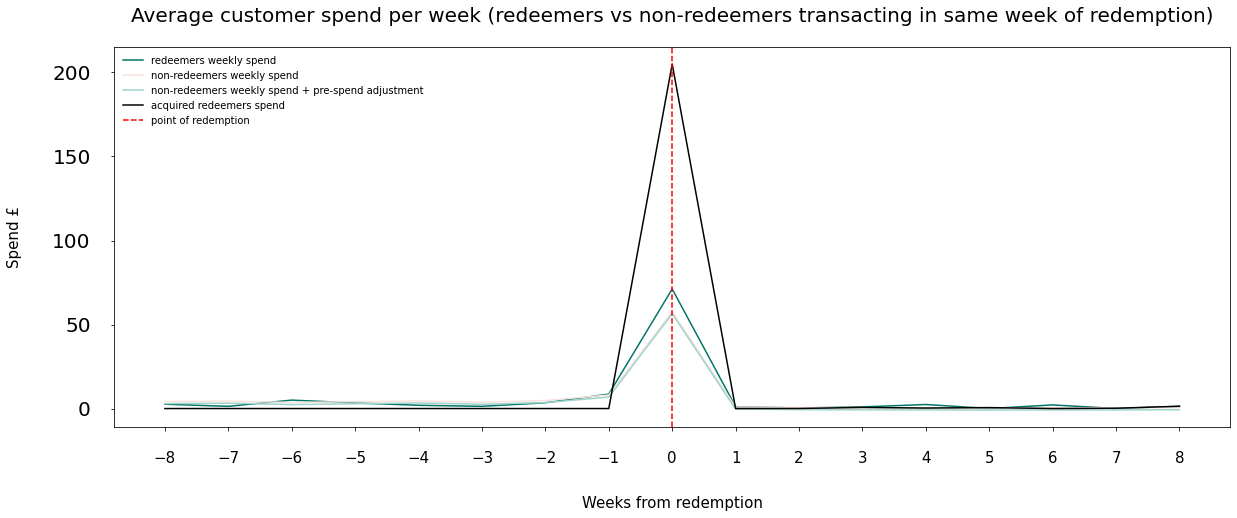

In [53]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20,7))
ax = fig.add_subplot(1,1,1)
x = cv2.index
ax.plot(x,cv1, label = 'redeemers weekly spend')
ax.plot(x,cv2, label = 'non-redeemers weekly spend')
ax.plot(x,cv2+cv_adjustment, label = 'non-redeemers weekly spend + pre-spend adjustment')
ax.plot(x,results_df11['acquired redeemer spend'], label = 'acquired redeemers spend', color = 'black')
ax.axvline(0, label='point of redemption', color = 'red',linestyle = '--')
plt.ylabel('Spend £')
plt.xlabel('Weeks from redemption')
ax.legend(fontsize = 10, loc = 'upper left')
ax.set_xticks(np.arange(-measurement_weeks,measurement_weeks+1))
#ax.set_yticks(np.arange(0,cv1.max()+2,2))
_ = plt.title('Average customer spend per week (redeemers vs non-redeemers transacting in same week of redemption)', size = 20)

### ATV Plot

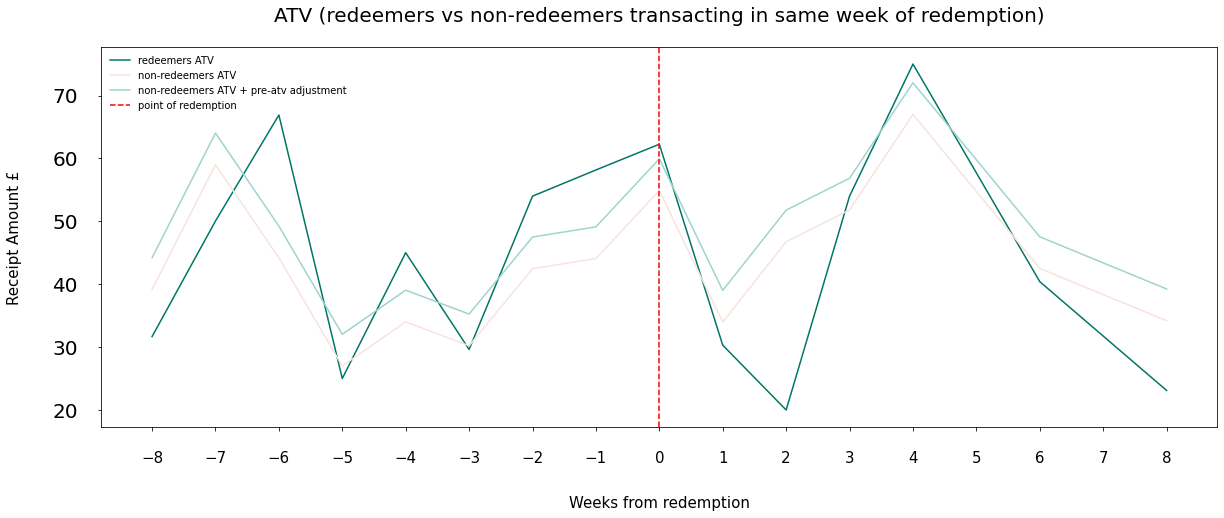

In [56]:
fig = plt.figure(figsize = (20,7))
ax = fig.add_subplot(1,1,1)
x = atv2.index
ax.plot(x,atv1, label = 'redeemers ATV')
ax.plot(x,atv2, label = 'non-redeemers ATV')
ax.plot(x,atv2+atv_adjustment, label = 'non-redeemers ATV + pre-atv adjustment')
#ax.plot(x,results_df11['acquired redeemer ATV'], label = 'acquired redeemers ATV', color = 'black')
ax.axvline(0, label='point of redemption', color = 'red',linestyle = '--')
plt.ylabel('Receipt Amount £')
plt.xlabel('Weeks from redemption')
ax.legend(fontsize = 10, loc = 'upper left')
ax.set_xticks(np.arange(-measurement_weeks,measurement_weeks+1))
min_atv = atv1.min()
max_atv = atv1.max()
#ax.set_yticks(np.arange(round(min_atv-1),round(max_atv+2)))
_ = plt.title('ATV (redeemers vs non-redeemers transacting in same week of redemption)', size = 20)

### ATF Plot

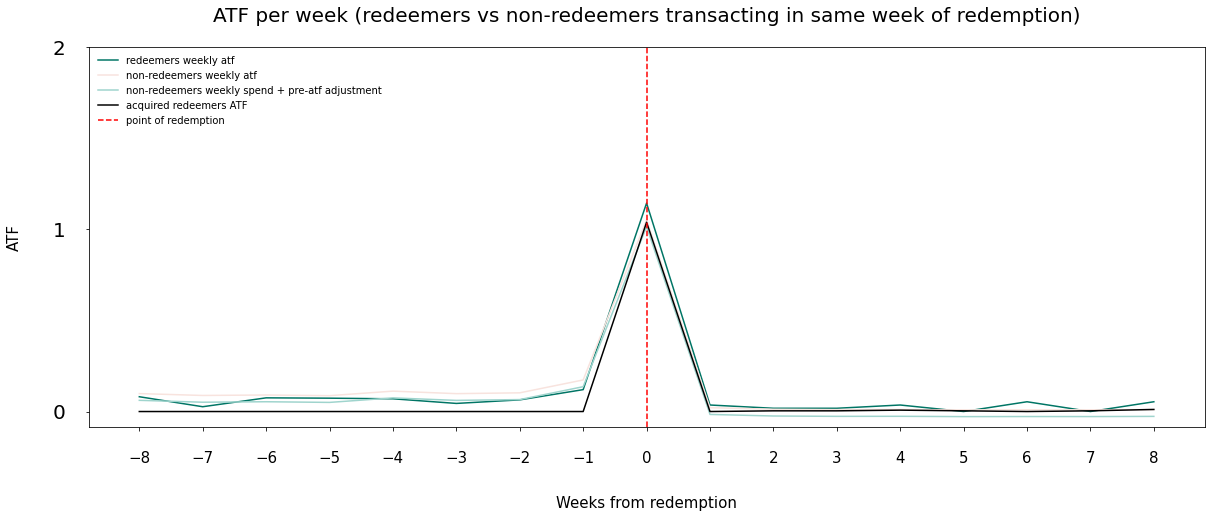

In [57]:
fig = plt.figure(figsize = (20,7))
ax = fig.add_subplot(1,1,1)
x = atf2.index
ax.plot(x,atf1, label = 'redeemers weekly atf')
ax.plot(x,atf2, label = 'non-redeemers weekly atf')
ax.plot(x,atf2+atf_adjustment, label = 'non-redeemers weekly spend + pre-atf adjustment')
ax.plot(x,results_df11['acquired redeemer ATF'], label = 'acquired redeemers ATF', color = 'black')
ax.axvline(0, label='point of redemption', color = 'red',linestyle = '--')
plt.ylabel('ATF')
plt.xlabel('Weeks from redemption')
ax.legend(fontsize = 10, loc = 'upper left')
ax.set_xticks(np.arange(-measurement_weeks,measurement_weeks+1))
min_atf = atf2.min()
max_atf = atf2.max()
ax.set_xticks(np.arange(-measurement_weeks,measurement_weeks+1))
ax.set_yticks(np.arange(0,max_atf*2))
_ = plt.title('ATF per week (redeemers vs non-redeemers transacting in same week of redemption)', size = 20)

### results_df12

In [58]:
#select number of weeks pre and post spend to base incremental on
weeks = measurement_weeks

pre_redeemer = cv1[(cv1.index>=-weeks)&(cv1.index<0)].mean()
post_redeemer = cv1[(cv1.index>0)&(cv1.index<=weeks)].mean()
pcent_redeemer = ((post_redeemer - pre_redeemer)/pre_redeemer)*100

pre_non_redeemer = cv2[(cv2.index>=-weeks)&(cv2.index<0)].mean()
post_non_redeemer = cv2[(cv2.index>0)&(cv2.index<=weeks)].mean()
pcent_non_redeemer = ((post_non_redeemer - pre_non_redeemer)/pre_non_redeemer)*100
ratio_non_redeemer = post_non_redeemer/pre_non_redeemer

diff = pcent_redeemer-pcent_non_redeemer

expected_spend = pre_redeemer*ratio_non_redeemer

incremental = post_redeemer - expected_spend

pcent_incremental = ((post_redeemer - expected_spend)/expected_spend)*100

revenue_impact = incremental*base_redeemer_count*measurement_weeks

results_df12 = pd.DataFrame([expected_spend,post_redeemer,incremental,pcent_incremental,weeks,base_redeemer_count,revenue_impact]
                            , index = ['redeemer expected post weekly spend','redeemer actual post weekly spend', 'weekly incremental'
                                       ,'% incremental','measurement weeks','existing redeemer volume','existing customer revenue impact'])

results_df12.rename_axis('metric', inplace = True)
results_df12.columns = ['value']
results_df12

,value
metric,
redeemer expected post weekly spend,0.384572
redeemer actual post weekly spend,1.042388
weekly incremental,0.657816
% incremental,171.051604
measurement weeks,8.000000
existing redeemer volume,55.000000
existing customer revenue impact,289.439242


### results_df13

In [59]:
#note: will be updating the value below to a calcualtion after looking into customer segment predictions
predicted_lifetime_value = 50
revenue_impact_acq = total_acquired*predicted_lifetime_value
results_df13 = pd.DataFrame([total_acquired,predicted_lifetime_value,revenue_impact_acq],index = ['aquired redeemer volume','predicted lifetime spend','acquired customer revenue impact'])
results_df13.rename_axis('metric', inplace = True)
results_df13.columns = ['value']
results_df13

,value
metric,
aquired redeemer volume,264
predicted lifetime spend,50
acquired customer revenue impact,13200


### results_df14

In [62]:
#get the cost in terms of the discount given out to the existing and acquired customer gorups 
existing_redeemer_receipts = df_live[(df_live.acquired_previous.isin(['previous']))&(df_live.redemption_segment.isin(['redeemer']))&(df_live.week_start.isin(week_start_list))]['receipt_id'].unique()
existing_cost = (df_offer[df_offer['receipt_id'].isin(existing_redeemer_receipts)]['price']*-1).sum()/100
acquired_redeemer_receipts = df_live[(df_live.acquired_previous.isin(['acquired']))&(df_live.week_start.isin(week_start_list))]['receipt_id'].unique()
acquired_cost = (df_offer[df_offer['receipt_id'].isin(acquired_redeemer_receipts)]['price']*-1).sum()/100

In [63]:
results_df14 = pd.DataFrame([existing_cost,acquired_cost],index = ['existing cost','acquired cost'])
results_df14.rename_axis('metric', inplace = True)
results_df14.columns = ['value']
results_df14

,value
metric,
existing cost,-112.0
acquired cost,-534.0


### results_df15

In [64]:
#ROI
roi_existing = (results_df12.loc['existing customer revenue impact'] - results_df14.loc['existing cost'])/results_df14.loc['existing cost']
roi_existing
roi_acquired = (results_df13.loc['acquired customer revenue impact'] - results_df14.loc['acquired cost'])/results_df14.loc['acquired cost']
roi_acquired


roi_total = ((results_df12.loc['existing customer revenue impact']+results_df13.loc['acquired customer revenue impact'])- results_df14.sum())/results_df14.sum()
roi_total

results_df15 = pd.DataFrame([roi_existing,roi_acquired,roi_total],index = ['existing customers ROI','acquired customers ROI','total ROI'])
results_df15.rename_axis('metric', inplace = True)
results_df15.columns = ['value']
results_df15



,value
metric,
existing customers ROI,-3.584279
acquired customers ROI,-25.719101
total ROI,-21.881485
